#  **1 The QM7 Dataset**

## Loading the Data, Preprocessing, Initial Data Analysis

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools


data = scipy.io.loadmat("qm7.mat")

# Extract the variables
R = data['R']
Z = data['Z']
T = data['T'].flatten()

print(f'R shape: {R.shape}')
print(f'Z shape: {Z.shape}')
print(f'T shape: {T.shape}')

R shape: (7165, 23, 3)
Z shape: (7165, 23)
T shape: (7165,)


Our starting point is a simple quantum-chemical dataset, the QM7 dataset, which can be downloaded
here:
http://quantum-machine.org/data/qm7.mat
1
(It is provided as a Matlab file, and it can be loaded in Python using the function scipy.io.loadmat.)
The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms. The 3d
coordinates of each atom in each molecule are available in the variable R. It is an array of size 7165×23×3
containing for each molecule and atom a triplet representing the 3d coordinates. The variable Z is an array
of size 7165×23 which gives for each molecule and atom of the molecule the corresponding atomic number.
An atomic number of 1 corresponds to a hydrogen atom (H), the number 6 corresponds to carbon (C), the
numbers 7 and 8 to nitrogen (N) and oxygen (O) respectively, and finally, the number 16 corresponds to
sulfur (S). If the number is zero, then it indicates that there is no atom at this index, and the corresponding
3d coordinate should therefore be ignored. This allows for representing in the same array molecules of
different sizes. In addition to these geometrical features of the molecule, the dataset also provides for
each molecule its atomization energy (computed via quantum-chemical simulation). These atomization
energy values are stored in the variable T, an array of size 7165.


## 1.1 Visualizing Molecules
There are a variety of libraries for rendering molecular geometries with various degrees of sophistication. A quick and dirty approach is to use the scatter plot function of matplotlib, where each point is an
atom (e.g. plotted according to its xy-coordinates and discarding the z-coordinate). Note that bonds are
not provided as part of QM7 because they are strictly speaking not needed to infer chemical properties
(bonds can be derived from atom coordinates). To better visualize the molecule, one can draw connections
between nearby atoms by plotting a line between two atoms if the Euclidean distance between the two is
smaller than a fixed threshold

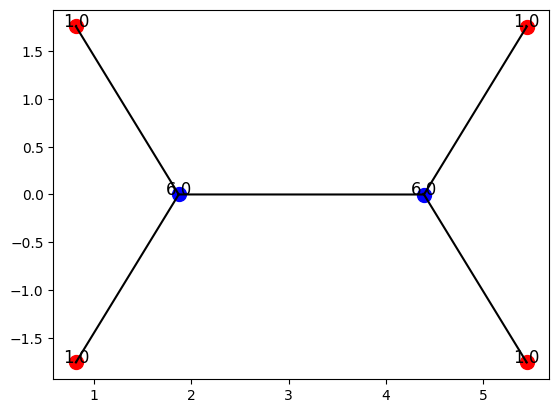

In [2]:
def visualize_molecule(molecule_idx, threshold=3):  # change threshold if bonds are wrong
    fig, ax = plt.subplots()
    
    # Get the coordinates and atomic numbers for the molecule
    coords = R[molecule_idx]
    atomic_numbers = Z[molecule_idx]
    
    # Define colors for different atoms
    colors = {1: 'red', 6: 'blue', 7: 'green', 8: 'purple', 16: 'orange'}
    
    # Plot the atoms
    for i, (x, y, z) in enumerate(coords):
        if atomic_numbers[i] != 0:  # Ignore non-atoms
            ax.scatter(x, y, s=100, color=colors.get(atomic_numbers[i], 'black'))
            ax.text(x, y, str(atomic_numbers[i]), fontsize=12, ha='center')
    
    # Plot the bonds
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            if atomic_numbers[i] != 0 and atomic_numbers[j] != 0:
                distance = np.linalg.norm(coords[i] - coords[j])
                #print(distance)
                if distance < threshold:
                    ax.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], 'k-')
    
    plt.show()

visualize_molecule(2)

## 2.1 Represenation - encoding


In [3]:
def encode_int_to_feature_vector(atom:int) -> list[int]: # return a one-hot-encoded vector of atom based on atom number
    unique_atoms = [1,6,7,8,16]
    atom_index = unique_atoms.index(atom)

    encoded_atom = np.zeros(5)
    encoded_atom[atom_index] = 1

    return encoded_atom

In [4]:
encode_int_to_feature_vector(16)

array([0., 0., 0., 0., 1.])

In [5]:
Z[5000]

array([6., 7., 7., 6., 6., 6., 8., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
def molecule_encoded(molecule: list[int]) -> list[int]:        # calculate all encoded atoms of one molecule and add them together
    encoded_molecule = np.zeros(5)
    for a in molecule:
        if a !=0:
            encoded_molecule += encode_int_to_feature_vector(a)
        else:
            return encoded_molecule
    
    return encoded_molecule
        
molecule_encoded(Z[2]), Z[2]

(array([4., 2., 0., 0., 0.]),
 array([6., 6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32))

In [7]:
def create_feature_vector(Z: list[list[int]]) -> list[list[int]]:     # return a 7165 x 5 array that contains all encoded molecules
    X = []

    for molecule in Z:
        m = list(molecule_encoded(molecule))
        X.append(m)
    return np.array(X)

## 2.2 training and testing model

In [8]:
# Assuming the necessary libraries are imported and the create_feature_vector function is defined
X = create_feature_vector(Z)
y = T

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

# Center the training and validation data
X_train_centered = X_train - X_train_mean
X_val_centered = X_val - X_train_mean
y_train_centered = y_train - y_train_mean
y_val_centered = y_val - y_train_mean  # This step is not strictly necessary for evaluation but ensures consistency

# Compute the covariance matrices using the centered training data
Sigma_xx = np.dot(X_train_centered.T, X_train_centered) / X_train_centered.shape[0]
Sigma_xt = np.dot(X_train_centered.T, y_train_centered) / X_train_centered.shape[0]

# Regularization parameter
lambda_reg = .0001

# Closed-form solution for the ridge regression weights
w = np.linalg.inv(Sigma_xx + lambda_reg * np.eye(Sigma_xx.shape[0])).dot(Sigma_xt)

# Evaluate the model on the validation set
y_val_pred_centered = np.dot(X_val_centered, w)
y_val_pred = y_val_pred_centered + y_train_mean  # Add back the mean to get the final predictions

# Calculate the Mean Absolute Error on the validation set
mae_val = np.mean(np.abs(y_val_pred - y_val))
print(f'Mean Absolute Error on validation set: {mae_val:.2f} kcal/mol')

# NEW: Center the test data
X_test_centered = X_test - X_train_mean
y_test_centered = y_test - y_train_mean

# Evaluate the model on the test set
y_test_pred_centered = np.dot(X_test_centered, w)
y_test_pred = y_test_pred_centered + y_train_mean  # Add back the mean to get the final predictions

# Calculate the Mean Absolute Error on the test set
mae_test = np.mean(np.abs(y_test_pred - y_test))
print(f'Mean Absolute Error on test set: {mae_test:.2f} kcal/mol')

# Output the learned weights
contributions = dict(zip(['H', 'C', 'N', 'O', 'S'], w))
print("Contribution of each atom type to the predicted atomization energy:")
for atom, weight in contributions.items():
    print(f"{atom}: {weight:.2f}")

# Calculate the contribution of each element i for each molecule individually in the test set
#for i, x in enumerate(X_test):
#    contributions_i = x * w
#    print(f"Molecule {x} contributions:")
#    for atom, contribution in zip(['H', 'C', 'N', 'O', 'S'], contributions_i):
#        print(f"  {atom}: {contribution:.2f}")
#    print(sum(contributions_i))

Mean Absolute Error on validation set: 15.85 kcal/mol
Mean Absolute Error on test set: 15.50 kcal/mol
Contribution of each atom type to the predicted atomization energy:
H: -68.65
C: -157.60
N: -102.69
O: -101.23
S: -80.70


## 3.2 


In [9]:
def distance3d(atom1xyz, atom2xyz):
    return np.linalg.norm(atom1xyz - atom2xyz)

In [10]:
def create_atom_pairs(molecule):
    pairs = []
    for i,a1 in enumerate(molecule):
        if a1 != 0:
            for j,a2 in enumerate(molecule):
                if not (j,i) in pairs:  # exclude double pairs
                    if a2 !=0 and i!=j:
                        pairs.append((i,j)) # atom numbers instead of indices would be append((a1,a2))

    return np.array(pairs) # values of the pairs are indices of atoms and not atom number 
                           # because atoms with same atom number are not distinguishable

In [11]:
create_atom_pairs(Z[0])

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 3],
       [2, 4],
       [3, 4]])

In [12]:
def gaussian(x, mean, variance):
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x - mean) ** 2) / variance)

def molecule_encoded_distances(atom_pairs: list[tuple[int]], mol_index: int):
    min_distance = 1
    max_distance = 18
    interval_steps = 0.17
    variance = 0.085  # You can adjust the variance value as needed
    intervals = np.zeros(round((max_distance -  min_distance)/ interval_steps), dtype=float)
    
    for p in atom_pairs:
        atom1 = R[mol_index, p[0]]  # xyz
        atom2 = R[mol_index, p[1]]  # xyz
        distance = distance3d(atom1, atom2)
        if distance <= max_distance:
            for i in range(len(intervals)):
                interval_start = min_distance + i * interval_steps
                interval_end = interval_start + interval_steps
                interval_center = (interval_start + interval_end) / 2
                gauss = gaussian(distance, interval_center, variance)
                
                intervals[i] += gauss

    return intervals

In [13]:
def encode_molecules_distances(Z: list[list[int]]) -> list[list[int]]:
    X = []

    for i,molecule in enumerate(Z):
        m = list(molecule_encoded_distances(create_atom_pairs(molecule), i))
        X.append(m)
    return np.array(X)

In [14]:
def encoded_molecule_pairs(molecule):
    vector = np.zeros(15)    # 6*5/2 atom pair combinations
    atom_types = [1, 6, 7, 8, 16] # Atom types: H (1), C (6), N (7), O (8), S (16)
    atom_pair_types = [[a, b] for a, b in itertools.combinations(atom_types, 2)] + [[a,a] for a in atom_types]

    atom_pair_types.sort()
    """ atom pair types are looking like this: 
       [[1, 1],
        [1, 6],
        [1, 7],
        [1, 8],
        [1, 16],
        [6, 6],
        [6, 7],
        [6, 8],
        [6, 16],
        [7, 7],
        [7, 8],
        [7, 16],
        [8, 8],
        [8, 16],
        [16, 16]]
    """

    atom_pairs_indices = create_atom_pairs(molecule)
    
    atom_pair_names = [ [molecule[a], molecule[b]] for (a,b) in atom_pairs_indices]
    
    for p in atom_pair_names:
        p = np.array(p).astype(int).tolist()
        if p in atom_pair_types:
            pos = atom_pair_types.index(p)
        elif [p[1], p[0]] in atom_pair_types:
            pos = atom_pair_types.index([p[1], p[0]])
        else:
            pos = -1  # Pair not found
        vector[pos] += 1

    return vector
    
encoded_molecule_pairs(Z[0])

array([6., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
def encode_molecules_names(Z: list[list[int]]) -> list[list[int]]:
    X = []

    for i,molecule in enumerate(Z):
        m = list(encoded_molecule_pairs(molecule))
        X.append(m)
    return np.array(X)

In [16]:
distances_map = encode_molecules_distances(Z)
print(distances_map)

[[1.94980377e-002 1.16537743e-001 4.95773157e-001 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.80504510e-002 1.68874170e-001 7.23651497e-001 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.25226251e-002 1.31336868e-001 5.45541606e-001 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [4.27139567e-002 2.59274459e-001 1.12261174e+000 ... 5.08098267e-135
  2.09516664e-141 6.14988459e-148]
 [5.10873519e-002 3.02481319e-001 1.27636076e+000 ... 4.48287738e-131
  2.31091677e-137 8.47983883e-144]
 [5.95315307e-002 3.54365807e-001 1.50203618e+000 ... 2.06106296e-139
  6.87048693e-146 1.63026385e-152]]


In [17]:
name_map = encode_molecules_names(Z)

In [18]:
distances_map.shape

(7165, 100)

In [19]:
name_map.shape

(7165, 15)

In [20]:
def combine_fmaps(distances_map, name_map):
    big_feature_map = []
    for i in range(len(distances_map)):
        outer_product = np.outer(distances_map[i],name_map[i]).flatten() # flattened: (7150,20,15) -> (7150,300) 
        big_feature_map.append(outer_product)

    big_feature_map = np.array(big_feature_map) 
    return big_feature_map

In [21]:
combined_map = combine_fmaps(distances_map, name_map)

In [22]:
combined_map.shape

(7165, 1500)

In [23]:

# Step 1: Define the predefined order
atom_types = ['H', 'C', 'N', 'O', 'S']

# Generate atom pairs
atom_pair_types = [a+b for a, b in itertools.combinations(atom_types, 2)] + [a+a for a in atom_types]

# Step 2: Create a dictionary to map each atom type to its position
order_dict = {atom: index for index, atom in enumerate(atom_types)}

# Step 3: Sort the atom_pair_types using the dictionary
sorted_atom_pair_types = sorted(atom_pair_types, key=lambda x: (order_dict[x[0]], order_dict[x[1]]))

print(sorted_atom_pair_types)

['HH', 'HC', 'HN', 'HO', 'HS', 'CC', 'CN', 'CO', 'CS', 'NN', 'NO', 'NS', 'OO', 'OS', 'SS']


In [28]:

X = combined_map
y = T

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

# Center the training and validation data
X_train_centered = X_train - X_train_mean
X_val_centered = X_val - X_train_mean
y_train_centered = y_train - y_train_mean
y_val_centered = y_val - y_train_mean  # This step is not strictly necessary for evaluation but ensures consistency

# Compute the covariance matrices using the centered training data
Sigma_xx = np.dot(X_train_centered.T, X_train_centered) / X_train_centered.shape[0]
Sigma_xt = np.dot(X_train_centered.T, y_train_centered) / X_train_centered.shape[0]

# Regularization parameter
lambda_reg = .001

# Closed-form solution for the ridge regression weights
w = np.linalg.inv(Sigma_xx + lambda_reg * np.eye(Sigma_xx.shape[0])).dot(Sigma_xt)


# Evaluate the model on the validation set
y_val_pred_centered = np.dot(X_val_centered, w)
y_val_pred = y_val_pred_centered + y_train_mean  # Add back the mean to get the final predictions

# Calculate the Mean Absolute Error on the validation set
mae_val = np.mean(np.abs(y_val_pred - y_val))
print(f'Mean Absolute Error on validation set: {mae_val:.2f} kcal/mol')

# NEW: Center the test data
X_test_centered = X_test - X_train_mean
y_test_centered = y_test - y_train_mean

# Evaluate the model on the test set
y_test_pred_centered = np.dot(X_test_centered, w)
y_test_pred = y_test_pred_centered + y_train_mean  # Add back the mean to get the final predictions

# Calculate the Mean Absolute Error on the test set
mae_test = np.mean(np.abs(y_test_pred - y_test))
print(f'Mean Absolute Error on test set: {mae_test:.3f} kcal/mol')

Mean Absolute Error on validation set: 10.64 kcal/mol
Mean Absolute Error on test set: 10.439 kcal/mol


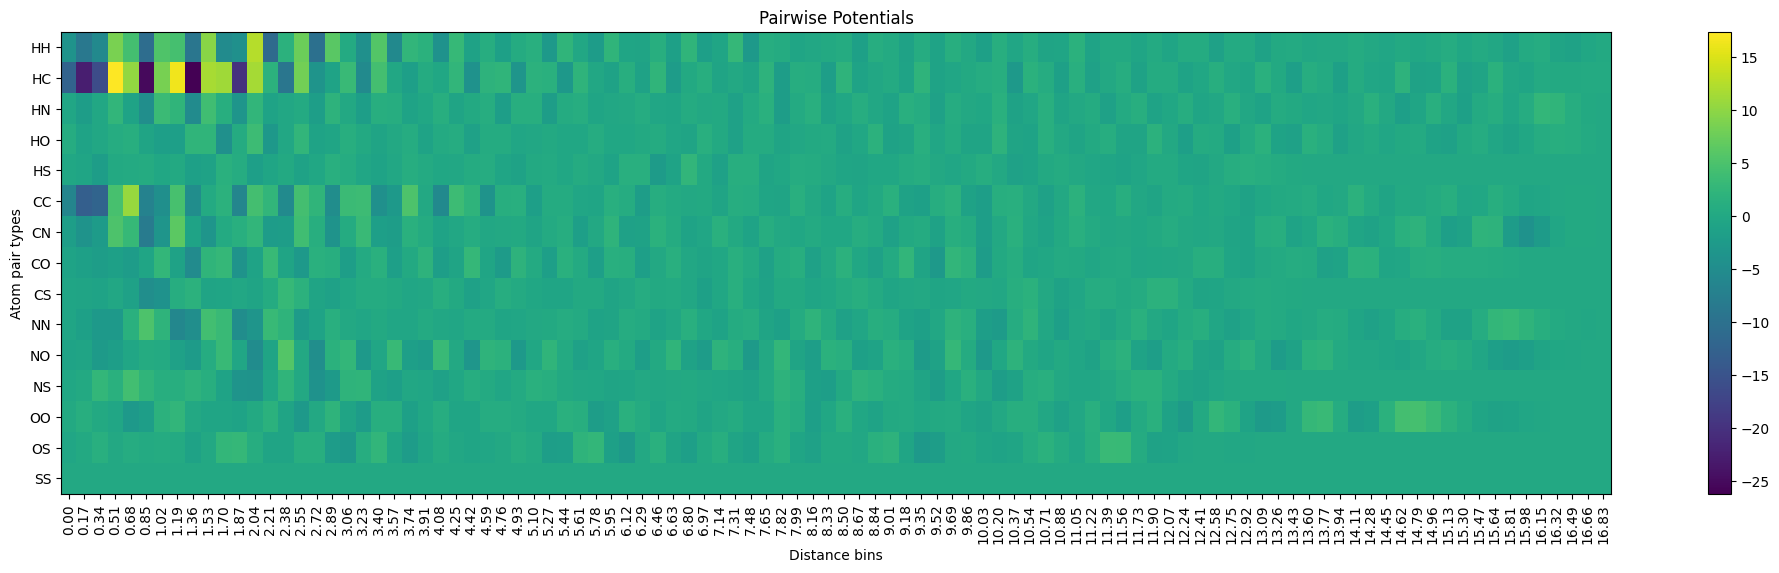

In [25]:
num_bins = int(w.shape[0]/15)
shaped_w = w.reshape((num_bins,15))

matrix = shaped_w.T


plt.figure(figsize=(25, 6))
plt.imshow(matrix, aspect='auto', cmap='viridis') 
plt.colorbar()  
plt.title('Pairwise Potentials')
plt.xlabel('Distance bins')
plt.ylabel('Atom pair types')
plt.yticks(ticks=np.arange(len(sorted_atom_pair_types)), labels=sorted_atom_pair_types) 
plt.xticks(ticks=np.arange(num_bins), labels=[f'{x * 0.17:.2f}'  for x in range(num_bins)], rotation=90) # interval_steps = 0.17 
plt.show()